<a href="https://colab.research.google.com/github/pubayankapat/Scalable_graph_handling/blob/main/Scalable_graph_handling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Dynamic graph simulator  

=== Fixed Dynamic Graph Clustering and Hierarchical Pathfinding ===

Graph Statistics (Fixed 10% Cluster Ratio):
- Nodes: 131
- Edges: 259
- Clusters: 13
- Actual cluster ratio: 0.10
- Expected clusters (10%): 13

Detailed Cluster Analysis:
- Average cluster size: 10.1
- Cluster size distribution: {0: 10, 1: 11, 2: 10, 3: 10, 4: 10, 5: 11, 6: 8, 7: 9, 8: 11, 9: 10, 10: 11, 11: 10, 12: 10}

Testing Routing Performance (50 random queries):
- Intra Cluster: 3 queries
- Adjacent Cluster: 40 queries
- Meta Cluster: 7 queries
- No Path: 0 queries

Routing Examples:
1. Intra-cluster: 8 → 9, Path: [8, 9]
2. Adjacent-cluster: 8 → 13, Path: [8, 76, 13]

Generating visualizations...


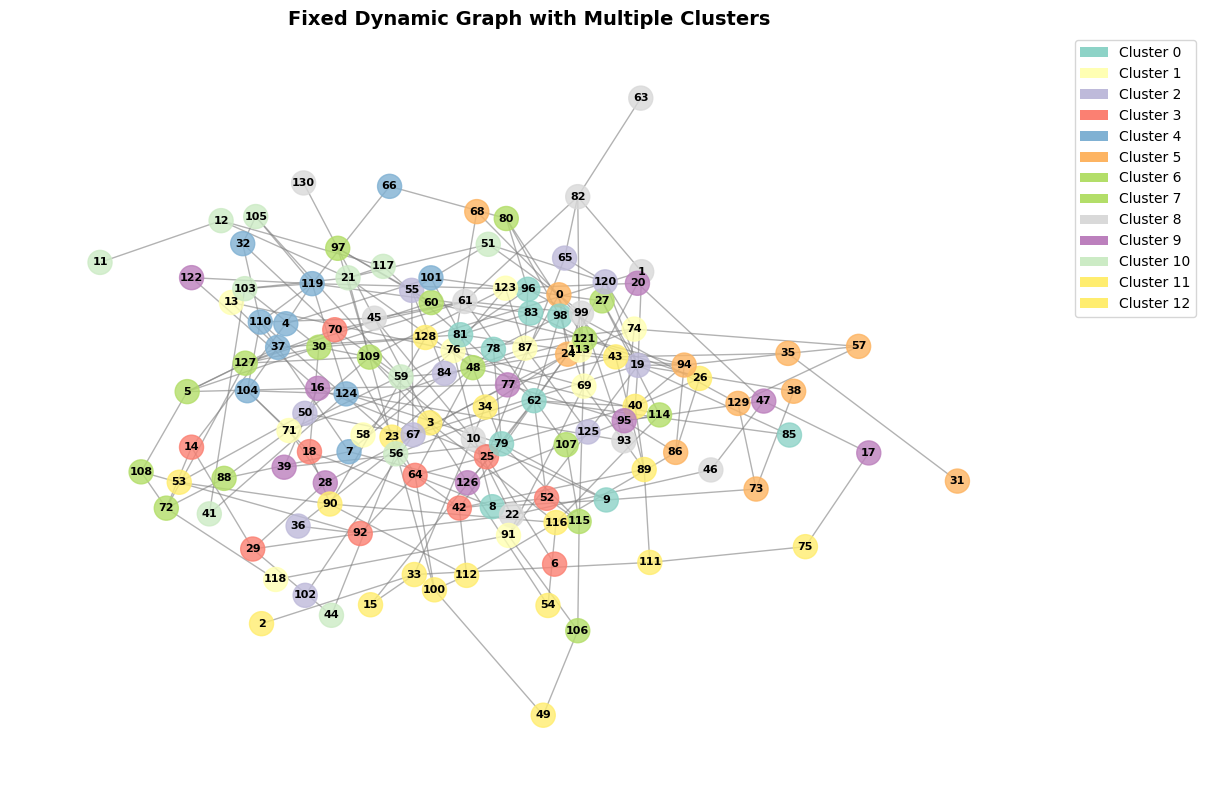

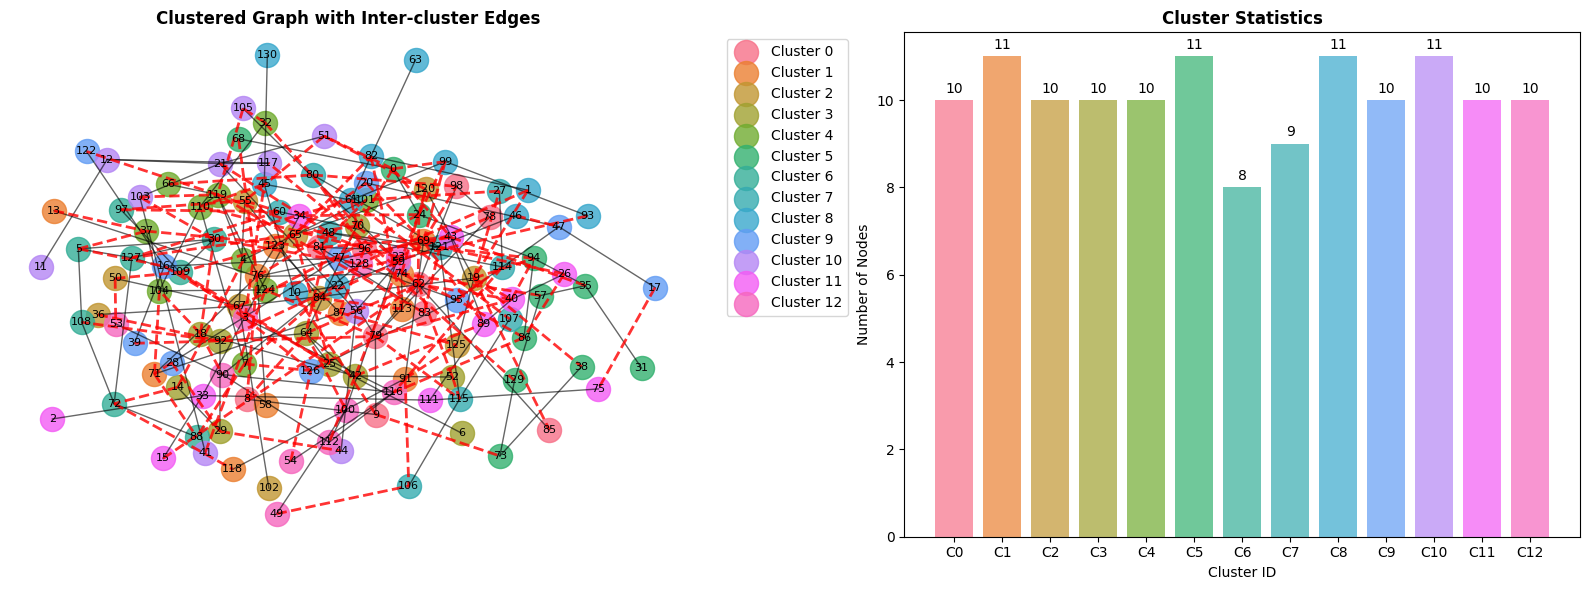

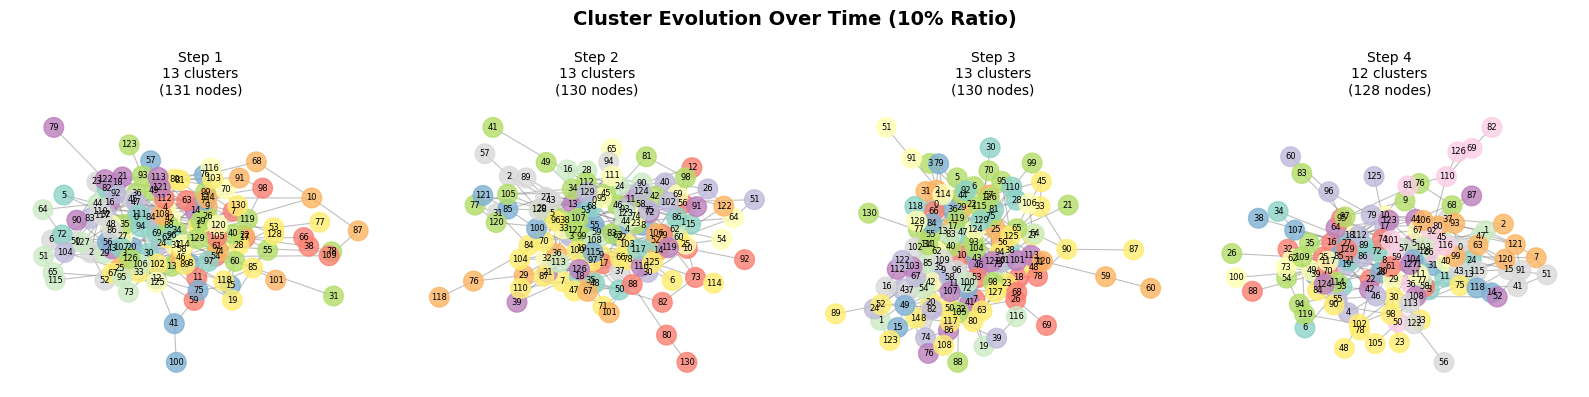


Demo completed successfully!

Running Batch Simulation...
Step 1: 130 nodes, 13 clusters
Step 2: 131 nodes, 13 clusters
Step 3: 129 nodes, 12 clusters
Step 4: 128 nodes, 12 clusters
Step 5: 128 nodes, 12 clusters


In [ ]:
import random
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
import seaborn as sns

# =============================================
# Dynamic Graph Simulator
# =============================================
class DynamicGraphSimulator:
    DURATION = 100  # seconds
    INIT_NODES = 130
    MIN_NODES = 123
    MAX_NODES = 137
    EDGE_UPDATE_PROB = 0.15  # 15% chance to update 1 or 2 edges
    EDGE_WEIGHT_UPDATE_PROB = 0.35  # 35% chance to update edge weight
    NODE_APPEAR_PROB = 0.15
    NODE_DISAPPEAR_PROB = 0.15
    EDGE_WEIGHT_MIN = 10
    EDGE_WEIGHT_MAX = 99

    def __init__(self):
        self.G = nx.Graph()
        self.next_node_id = self.INIT_NODES

    def ensure_connected(self):
        """Ensure the graph remains connected by adding edges between components"""
        while not nx.is_connected(self.G):
            components = list(nx.connected_components(self.G))
            if len(components) < 2:
                break
            u = random.choice(list(components[0]))
            v = random.choice(list(components[1]))
            self.G.add_edge(u, v, weight=random.randint(self.EDGE_WEIGHT_MIN, self.EDGE_WEIGHT_MAX))

    def random_edge(self):
        """Get a random edge from the graph"""
        nodes = list(self.G.nodes)
        if len(nodes) < 2:
            return None
        u, v = random.sample(nodes, 2)
        return (u, v)

    def add_random_edge(self):
        """Add a random edge to the graph"""
        nodes = list(self.G.nodes)
        if len(nodes) < 2:
            return
        possible = [(u, v) for u in nodes for v in nodes if u != v and not self.G.has_edge(u, v)]
        if possible:
            u, v = random.choice(possible)
            self.G.add_edge(u, v, weight=random.randint(self.EDGE_WEIGHT_MIN, self.EDGE_WEIGHT_MAX))

    def remove_random_edge(self):
        """Remove a random edge while maintaining connectivity"""
        if self.G.number_of_edges() > self.G.number_of_nodes() - 1:
            edge = random.choice(list(self.G.edges))
            weight = self.G.edges[edge]['weight']
            self.G.remove_edge(*edge)
            if not nx.is_connected(self.G):
                self.G.add_edge(*edge, weight=weight)  # revert if disconnects

    def add_node(self):
        """Add a new node to the graph"""
        self.G.add_node(self.next_node_id)
        existing_nodes = set(self.G.nodes) - {self.next_node_id}
        if existing_nodes:
            existing = random.choice(list(existing_nodes))
            self.G.add_edge(self.next_node_id, existing, weight=random.randint(self.EDGE_WEIGHT_MIN, self.EDGE_WEIGHT_MAX))
        self.next_node_id += 1

    def remove_node(self):
        """Remove a random node while maintaining connectivity"""
        if self.G.number_of_nodes() > self.MIN_NODES:
            node = random.choice(list(self.G.nodes))
            edges = list(self.G.edges(node, data=True))
            self.G.remove_node(node)
            if not nx.is_connected(self.G):
                self.G.add_node(node)
                existing_nodes = set(self.G.nodes) - {node}
                if existing_nodes:
                    existing = random.choice(list(existing_nodes))
                    self.G.add_edge(node, existing, weight=random.randint(self.EDGE_WEIGHT_MIN, self.EDGE_WEIGHT_MAX))

    def update_random_edge_weight(self):
        """Update the weight of a random edge"""
        if self.G.number_of_edges() > 0:
            edge = random.choice(list(self.G.edges))
            self.G.edges[edge]['weight'] = random.randint(self.EDGE_WEIGHT_MIN, self.EDGE_WEIGHT_MAX)

    def get_graph_snapshot(self):
        """Generate a new graph snapshot with dynamic changes"""
        self.G = nx.Graph()
        self.G.add_nodes_from(range(self.INIT_NODES))
        for _ in range(self.INIT_NODES * 2):
            self.add_random_edge()
        self.ensure_connected()
        self.next_node_id = self.INIT_NODES

        for _ in range(5):
            if random.random() < self.NODE_APPEAR_PROB and self.G.number_of_nodes() < self.MAX_NODES:
                self.add_node()
            elif random.random() < self.NODE_DISAPPEAR_PROB and self.G.number_of_nodes() > self.MIN_NODES:
                self.remove_node()

            num_edge_updates = 1 if random.random() < self.EDGE_UPDATE_PROB else 2
            for _ in range(num_edge_updates):
                if random.random() < 0.5:
                    self.add_random_edge()
                else:
                    self.remove_random_edge()

            if random.random() < self.EDGE_WEIGHT_UPDATE_PROB:
                self.update_random_edge_weight()

            self.ensure_connected()
        return self.G

# =============================================
# Fixed Seed-Based Clustering Algorithm (10% Ratio)
# =============================================
def seed_oriented_clustering_fixed(G, cluster_ratio=0.1, max_cluster_size_ratio=0.4):
    """
    Fixed seed-based clustering algorithm with proper cluster boundaries

    Parameters:
    -----------
    G : networkx.Graph
        The input graph to be clustered
    cluster_ratio : float, default=0.1
        Ratio of nodes to be selected as seeds (10% of total nodes)
    max_cluster_size_ratio : float, default=0.4
        Maximum cluster size as ratio of total nodes (prevents oversized clusters)

    Returns:
    --------
    dict
        Mapping of nodes to their cluster IDs
    """
    n = G.number_of_nodes()
    if n == 0:
        return {}

    # Calculate cluster parameters
    num_clusters = max(1, int(cluster_ratio * n))
    max_cluster_size = max(3, int(max_cluster_size_ratio * n))  # Limit cluster size

    # Enhanced seed selection with diversity
    degrees = dict(G.degree())
    try:
        betweenness = nx.betweenness_centrality(G)
    except:
        betweenness = {node: 0 for node in G.nodes()}

    # Composite score for better seed distribution
    composite_scores = {}
    for node in G.nodes():
        score = 0.7 * degrees[node] + 0.3 * betweenness[node] * n
        composite_scores[node] = score

    # Select diverse seeds (avoid close neighbors)
    sorted_nodes = sorted(composite_scores, key=composite_scores.get, reverse=True)
    seeds = []
    min_seed_distance = 2  # Minimum distance between seeds

    for node in sorted_nodes:
        if len(seeds) >= num_clusters:
            break

        # Check if this node is far enough from existing seeds
        too_close = False
        for existing_seed in seeds:
            try:
                if nx.shortest_path_length(G, node, existing_seed) < min_seed_distance:
                    too_close = True
                    break
            except nx.NetworkXNoPath:
                continue

        if not too_close:
            seeds.append(node)

    # Ensure we have enough seeds
    while len(seeds) < num_clusters and len(seeds) < len(sorted_nodes):
        remaining = [n for n in sorted_nodes if n not in seeds]
        if remaining:
            seeds.append(remaining[0])
        else:
            break

    # Initialize clusters
    assigned = set()
    clusters = {}
    cluster_sizes = {}

    # Assign seeds to their own clusters
    for i, seed in enumerate(seeds):
        clusters[seed] = i
        assigned.add(seed)
        cluster_sizes[i] = 1

    # Balanced expansion using round-robin approach
    active_clusters = list(range(len(seeds)))

    while active_clusters:
        clusters_to_remove = []

        for cluster_id in active_clusters:
            # Skip if cluster is at maximum size
            if cluster_sizes[cluster_id] >= max_cluster_size:
                clusters_to_remove.append(cluster_id)
                continue

            # Find cluster nodes
            cluster_nodes = [n for n, c in clusters.items() if c == cluster_id]

            # Find frontier nodes
            frontier = set()
            for node in cluster_nodes:
                frontier.update(set(G.neighbors(node)) - assigned)

            if not frontier:
                clusters_to_remove.append(cluster_id)
                continue

            # Find best candidate for this cluster
            best_node = None
            best_score = float('-inf')

            for candidate in frontier:
                # Calculate connection strength to this cluster
                connections = sum(1 for n in cluster_nodes if G.has_edge(candidate, n))
                score = connections + composite_scores[candidate] * 0.1

                if score > best_score:
                    best_score = score
                    best_node = candidate

            # Add best node to cluster
            if best_node is not None:
                clusters[best_node] = cluster_id
                assigned.add(best_node)
                cluster_sizes[cluster_id] += 1

        # Remove inactive clusters
        for cluster_id in clusters_to_remove:
            active_clusters.remove(cluster_id)

    # Assign remaining unassigned nodes
    unassigned = set(G.nodes()) - assigned
    for node in unassigned:
        best_cluster = None
        best_score = float('-inf')

        for cluster_id in range(len(seeds)):
            if cluster_sizes[cluster_id] >= max_cluster_size:
                continue

            cluster_nodes = [n for n, c in clusters.items() if c == cluster_id]

            # Calculate connection score to this cluster
            connections = sum(1 for n in cluster_nodes if G.has_edge(node, n))
            if connections > best_score:
                best_score = connections
                best_cluster = cluster_id

        if best_cluster is not None:
            clusters[node] = best_cluster
            cluster_sizes[best_cluster] += 1
        else:
            # Create new cluster for isolated nodes
            new_cluster_id = len(seeds)
            clusters[node] = new_cluster_id
            seeds.append(node)
            cluster_sizes[new_cluster_id] = 1

    return clusters

def force_minimum_clusters(G, min_clusters=3):
    """
    Force creation of minimum number of clusters using manual partitioning
    """
    if G.number_of_nodes() < min_clusters:
        min_clusters = G.number_of_nodes()

    # Manual partitioning as fallback
    nodes = list(G.nodes())
    clusters = {}
    nodes_per_cluster = max(1, len(nodes) // min_clusters)

    for i, node in enumerate(nodes):
        cluster_id = min(i // nodes_per_cluster, min_clusters - 1)
        clusters[node] = cluster_id

    return clusters

# =============================================
# Enhanced Meta-Graph Construction
# =============================================
def build_enhanced_meta_graph(G, clusters):
    """
    Enhanced meta-graph construction with weighted edges
    """
    meta_graph = nx.Graph()
    cluster_ids = set(clusters.values())

    # Add all cluster IDs as nodes
    for cluster_id in cluster_ids:
        cluster_nodes = [n for n, c in clusters.items() if c == cluster_id]
        meta_graph.add_node(cluster_id, size=len(cluster_nodes))

    # Add weighted edges between clusters
    for u, v in G.edges():
        cu, cv = clusters[u], clusters[v]
        if cu != cv:
            weight = G[u][v].get('weight', 1)
            if meta_graph.has_edge(cu, cv):
                # Update edge weight (use minimum for best connection)
                current_weight = meta_graph[cu][cv]['weight']
                meta_graph[cu][cv]['weight'] = min(current_weight, weight)
            else:
                meta_graph.add_edge(cu, cv, weight=weight)

    return meta_graph

def are_clusters_adjacent(clusters, G, src_cluster, tgt_cluster):
    """Check if two clusters are adjacent (directly connected)"""
    for u, v in G.edges():
        if (clusters[u] == src_cluster and clusters[v] == tgt_cluster) or \
           (clusters[v] == src_cluster and clusters[u] == tgt_cluster):
            return True
    return False

def get_gateway_pairs(G, clusters, src_cluster, tgt_cluster):
    """Get gateway nodes between two adjacent clusters"""
    gateways_src = [n for n in G.nodes() if clusters[n] == src_cluster and
                    any(clusters[nb] == tgt_cluster for nb in G.neighbors(n))]
    gateways_tgt = [n for n in G.nodes() if clusters[n] == tgt_cluster and
                    any(clusters[nb] == src_cluster for nb in G.neighbors(n))]
    return gateways_src, gateways_tgt

# =============================================
# Enhanced Hierarchical Pathfinding (Three-Tier Routing)
# =============================================
def find_cluster_path(meta_graph, src_cluster, tgt_cluster):
    """Find shortest path between clusters in meta-graph"""
    try:
        return nx.shortest_path(meta_graph, src_cluster, tgt_cluster, weight='weight')
    except nx.NetworkXNoPath:
        return None

def find_path(G, clusters, source, target):
    """
    Enhanced three-tier hierarchical pathfinding:
    1. Intra-cluster: Source and destination in same cluster
    2. Adjacent-cluster: Source and destination in neighboring clusters
    3. Meta-cluster: Source and destination in non-adjacent clusters
    """
    if source not in clusters or target not in clusters:
        return None, "Node not in clusters"

    src_cluster = clusters[source]
    tgt_cluster = clusters[target]

    # Case 1: Intra-cluster routing
    if src_cluster == tgt_cluster:
        try:
            return nx.shortest_path(G, source, target, weight='weight'), "Intra-cluster"
        except nx.NetworkXNoPath:
            return None, "No path"

    # Case 2: Adjacent-cluster routing
    elif are_clusters_adjacent(clusters, G, src_cluster, tgt_cluster):
        gateways_src, gateways_tgt = get_gateway_pairs(G, clusters, src_cluster, tgt_cluster)
        min_path = None
        min_len = float('inf')

        for g_src in gateways_src:
            for g_tgt in gateways_tgt:
                try:
                    path1 = nx.shortest_path(G, source, g_src, weight='weight')
                    path2 = nx.shortest_path(G, g_src, g_tgt, weight='weight')
                    path3 = nx.shortest_path(G, g_tgt, target, weight='weight')
                    full_path = path1[:-1] + path2[:-1] + path3
                    if len(full_path) < min_len:
                        min_len = len(full_path)
                        min_path = full_path
                except nx.NetworkXNoPath:
                    continue

        return min_path, "Adjacent-cluster"

    # Case 3: Meta-cluster routing
    else:
        meta_graph = build_enhanced_meta_graph(G, clusters)
        cluster_path = find_cluster_path(meta_graph, src_cluster, tgt_cluster)

        if not cluster_path:
            return None, "No meta-cluster path"

        # Find gateway nodes between clusters along cluster_path
        full_path = [source]
        current = source

        for i in range(len(cluster_path)-1):
            c_from, c_to = cluster_path[i], cluster_path[i+1]
            gateways_src, gateways_tgt = get_gateway_pairs(G, clusters, c_from, c_to)

            # Find the closest gateway from current node
            min_subpath = None
            min_len = float('inf')

            for g_src in gateways_src:
                try:
                    subpath = nx.shortest_path(G, current, g_src, weight='weight')
                    if len(subpath) < min_len:
                        min_len = len(subpath)
                        min_subpath = subpath
                except nx.NetworkXNoPath:
                    continue

            if min_subpath is None or not gateways_tgt:
                return None, "No gateway path"

            full_path += min_subpath[1:]
            next_gateway = gateways_tgt[0]
            if next_gateway not in full_path:
                full_path.append(next_gateway)
            current = next_gateway

        # Final hop to target
        try:
            subpath = nx.shortest_path(G, current, target, weight='weight')
            full_path += subpath[1:]
        except nx.NetworkXNoPath:
            return None, "No path to target"

        return full_path, "Meta-cluster"

# =============================================
# Visualization Functions
# =============================================
def plot_clustered_graph(G, clusters, title="Dynamic Graph with Clusters",
                        figsize=(12, 8), node_size=300, with_labels=True):
    """Plot graph with nodes colored by cluster membership"""
    plt.figure(figsize=figsize)

    # Create position layout
    pos = nx.spring_layout(G, seed=42, k=1, iterations=50)

    # Get unique clusters and create color map
    unique_clusters = list(set(clusters.values()))
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_clusters)))
    cluster_colors = {cluster: colors[i] for i, cluster in enumerate(unique_clusters)}

    # Color nodes by cluster
    node_colors = [cluster_colors[clusters[node]] for node in G.nodes()]

    # Draw edges first (so they appear behind nodes)
    nx.draw_networkx_edges(G, pos, alpha=0.6, edge_color='gray', width=1)

    # Draw nodes with cluster colors
    nx.draw_networkx_nodes(G, pos, node_color=node_colors,
                          node_size=node_size, alpha=0.8)

    # Add labels if requested
    if with_labels:
        nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')

    plt.title(title, fontsize=14, fontweight='bold')
    plt.axis('off')

    # Create legend
    legend_elements = [plt.Circle((0,0), 1, facecolor=cluster_colors[cluster],
                                 label=f'Cluster {cluster}')
                      for cluster in unique_clusters]
    plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.15, 1))

    plt.tight_layout()
    plt.show()

def plot_cluster_evolution(simulator, steps=5):
    """Plot the evolution of clusters over multiple time steps"""
    fig, axes = plt.subplots(1, steps, figsize=(4*steps, 4))
    if steps == 1:
        axes = [axes]

    for i in range(steps):
        G = simulator.get_graph_snapshot()
        clusters = seed_oriented_clustering_fixed(G, cluster_ratio=0.1)

        # Force minimum clusters if needed
        min_required_clusters = max(2, int(0.1 * G.number_of_nodes()))
        if len(set(clusters.values())) < min_required_clusters:
            clusters = force_minimum_clusters(G, min_clusters=min_required_clusters)

        # Plot on subplot
        ax = axes[i]
        plt.sca(ax)

        pos = nx.spring_layout(G, seed=42)
        unique_clusters = list(set(clusters.values()))
        colors = plt.cm.Set3(np.linspace(0, 1, len(unique_clusters)))
        cluster_colors = {cluster: colors[j] for j, cluster in enumerate(unique_clusters)}
        node_colors = [cluster_colors[clusters[node]] for node in G.nodes()]

        nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color='gray', width=0.8)
        nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=200, alpha=0.8)
        nx.draw_networkx_labels(G, pos, font_size=6)

        ax.set_title(f'Step {i+1}\n{len(unique_clusters)} clusters\n({G.number_of_nodes()} nodes)', fontsize=10)
        ax.axis('off')

    plt.suptitle('Cluster Evolution Over Time (10% Ratio)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

def plot_advanced_cluster_visualization(G, clusters):
    """Advanced visualization with cluster statistics and inter-cluster connections"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Main graph visualization
    pos = nx.spring_layout(G, seed=42, k=1.5, iterations=50)
    unique_clusters = list(set(clusters.values()))
    colors = sns.color_palette("husl", len(unique_clusters))
    cluster_colors = {cluster: colors[i] for i, cluster in enumerate(unique_clusters)}

    # Plot main graph
    ax1.set_title('Clustered Graph with Inter-cluster Edges', fontsize=12, fontweight='bold')

    # Draw intra-cluster edges
    for edge in G.edges():
        u, v = edge
        if clusters[u] == clusters[v]:
            x1, y1 = pos[u]
            x2, y2 = pos[v]
            ax1.plot([x1, x2], [y1, y2], 'k-', alpha=0.6, linewidth=1)

    # Draw inter-cluster edges (highlighted)
    for edge in G.edges():
        u, v = edge
        if clusters[u] != clusters[v]:
            x1, y1 = pos[u]
            x2, y2 = pos[v]
            ax1.plot([x1, x2], [y1, y2], 'r--', alpha=0.8, linewidth=2)

    # Draw nodes
    for cluster in unique_clusters:
        cluster_nodes = [n for n in G.nodes() if clusters[n] == cluster]
        node_pos = np.array([pos[n] for n in cluster_nodes])
        ax1.scatter(node_pos[:, 0], node_pos[:, 1],
                   c=[cluster_colors[cluster]], s=300, alpha=0.8,
                   label=f'Cluster {cluster}')

        # Add node labels
        for node in cluster_nodes:
            ax1.annotate(str(node), pos[node], fontsize=8, ha='center', va='center')

    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.axis('off')

    # Cluster statistics
    ax2.set_title('Cluster Statistics', fontsize=12, fontweight='bold')

    cluster_sizes = [sum(1 for n in G.nodes() if clusters[n] == cluster)
                    for cluster in unique_clusters]

    bars = ax2.bar(range(len(unique_clusters)), cluster_sizes,
                   color=[cluster_colors[cluster] for cluster in unique_clusters],
                   alpha=0.7)

    ax2.set_xlabel('Cluster ID')
    ax2.set_ylabel('Number of Nodes')
    ax2.set_xticks(range(len(unique_clusters)))
    ax2.set_xticklabels([f'C{cluster}' for cluster in unique_clusters])

    # Add value labels on bars
    for bar, size in zip(bars, cluster_sizes):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{size}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# =============================================
# Analysis and Utility Functions
# =============================================
def analyze_clusters(G, clusters):
    """Analyze clustering results and return statistics"""
    if not clusters:
        return {}

    cluster_stats = {}

    # Count cluster sizes
    cluster_sizes = {}
    for node, cluster_id in clusters.items():
        cluster_sizes[cluster_id] = cluster_sizes.get(cluster_id, 0) + 1

    # Calculate intra-cluster connectivity
    intra_cluster_edges = {}
    for cluster_id in cluster_sizes:
        nodes_in_cluster = [n for n, c in clusters.items() if c == cluster_id]
        subgraph = G.subgraph(nodes_in_cluster)
        intra_cluster_edges[cluster_id] = subgraph.number_of_edges()

    cluster_stats = {
        'num_clusters': len(cluster_sizes),
        'cluster_sizes': cluster_sizes,
        'avg_cluster_size': np.mean(list(cluster_sizes.values())),
        'intra_cluster_edges': intra_cluster_edges,
        'clustering_ratio': len(cluster_sizes) / G.number_of_nodes()
    }

    return cluster_stats

def get_cluster_adjacency_matrix(G, clusters):
    """Create cluster adjacency matrix for meta-graph construction"""
    cluster_ids = set(clusters.values())
    adj_matrix = np.zeros((len(cluster_ids), len(cluster_ids)))
    id_mapping = {cid: i for i, cid in enumerate(sorted(cluster_ids))}

    for u, v in G.edges():
        cu, cv = clusters[u], clusters[v]
        if cu != cv:
            i, j = id_mapping[cu], id_mapping[cv]
            adj_matrix[i][j] = 1
            adj_matrix[j][i] = 1

    return adj_matrix, id_mapping

# =============================================
# Performance Testing Functions
# =============================================
def test_routing_performance(G, clusters, num_tests=10):
    """Test routing performance across different scenarios"""
    results = {
        'intra_cluster': 0,
        'adjacent_cluster': 0,
        'meta_cluster': 0,
        'no_path': 0
    }

    nodes = list(G.nodes())

    for _ in range(num_tests):
        if len(nodes) < 2:
            continue
        src, tgt = random.sample(nodes, 2)
        path, mode = find_path(G, clusters, src, tgt)

        if path is None:
            results['no_path'] += 1
        elif mode == "Intra-cluster":
            results['intra_cluster'] += 1
        elif mode == "Adjacent-cluster":
            results['adjacent_cluster'] += 1
        elif mode == "Meta-cluster":
            results['meta_cluster'] += 1

    return results

def demonstrate_all_routing_modes(G, clusters):
    """
    Demonstrate all three routing modes
    """
    nodes = list(G.nodes())
    unique_clusters = set(clusters.values())

    # Find examples for each routing mode
    print("\nRouting Examples:")

    # 1. Intra-cluster example
    for cluster_id in unique_clusters:
        cluster_nodes = [n for n in nodes if clusters[n] == cluster_id]
        if len(cluster_nodes) >= 2:
            src, tgt = cluster_nodes[0], cluster_nodes[1]
            path, mode = find_path(G, clusters, src, tgt)
            print(f"1. {mode}: {src} → {tgt}, Path: {path}")
            break

    # 2. Adjacent-cluster example
    meta_graph = build_enhanced_meta_graph(G, clusters)
    for edge in meta_graph.edges():
        c1, c2 = edge
        c1_nodes = [n for n in nodes if clusters[n] == c1]
        c2_nodes = [n for n in nodes if clusters[n] == c2]
        if c1_nodes and c2_nodes:
            src, tgt = c1_nodes[0], c2_nodes[0]
            path, mode = find_path(G, clusters, src, tgt)
            print(f"2. {mode}: {src} → {tgt}, Path: {path}")
            break

    # 3. Meta-cluster example
    if len(unique_clusters) >= 3:
        cluster_list = list(unique_clusters)
        try:
            # Find non-adjacent clusters
            path_in_meta = nx.shortest_path(meta_graph, cluster_list[0], cluster_list[-1])
            if len(path_in_meta) > 2:  # Multi-hop path
                c1_nodes = [n for n in nodes if clusters[n] == cluster_list[0]]
                c2_nodes = [n for n in nodes if clusters[n] == cluster_list[-1]]
                if c1_nodes and c2_nodes:
                    src, tgt = c1_nodes[0], c2_nodes[0]
                    path, mode = find_path(G, clusters, src, tgt)
                    print(f"3. {mode}: {src} → {tgt}, Path: {path}")
        except:
            print("3. Meta-cluster routing: No suitable example found")

# =============================================
# Main Execution and Demonstration
# =============================================
def main_fixed():
    """
    Fixed main function with guaranteed multiple clusters
    """
    print("=== Fixed Dynamic Graph Clustering and Hierarchical Pathfinding ===\n")

    simulator = DynamicGraphSimulator()
    G = simulator.get_graph_snapshot()

    # Try fixed clustering first
    clusters = seed_oriented_clustering_fixed(G, cluster_ratio=0.1)

    # Force minimum clusters if needed
    min_required_clusters = max(2, int(0.1 * G.number_of_nodes()))
    if len(set(clusters.values())) < min_required_clusters:
        print(f"Warning: Only {len(set(clusters.values()))} clusters found. Forcing {min_required_clusters} clusters...")
        clusters = force_minimum_clusters(G, min_clusters=min_required_clusters)

    # Print statistics
    unique_clusters = set(clusters.values())
    print(f"Graph Statistics (Fixed 10% Cluster Ratio):")
    print(f"- Nodes: {G.number_of_nodes()}")
    print(f"- Edges: {G.number_of_edges()}")
    print(f"- Clusters: {len(unique_clusters)}")
    print(f"- Actual cluster ratio: {len(unique_clusters) / G.number_of_nodes():.2f}")
    print(f"- Expected clusters (10%): {int(0.1 * G.number_of_nodes())}")

    # Detailed cluster analysis
    stats = analyze_clusters(G, clusters)
    print(f"\nDetailed Cluster Analysis:")
    print(f"- Average cluster size: {stats['avg_cluster_size']:.1f}")
    print(f"- Cluster size distribution: {stats['cluster_sizes']}")

    # Test routing performance
    print(f"\nTesting Routing Performance (50 random queries):")
    perf_results = test_routing_performance(G, clusters, num_tests=50)
    for mode, count in perf_results.items():
        print(f"- {mode.replace('_', ' ').title()}: {count} queries")

    # Demonstrate all routing modes
    demonstrate_all_routing_modes(G, clusters)

    # Visualizations
    print(f"\nGenerating visualizations...")

    # Basic cluster visualization
    plot_clustered_graph(G, clusters, "Fixed Dynamic Graph with Multiple Clusters")

    # Advanced visualization
    plot_advanced_cluster_visualization(G, clusters)

    # Evolution over time
    plot_cluster_evolution(simulator, steps=4)

    print(f"\nDemo completed successfully!")

    return G, clusters

def run_batch_simulation(steps=10):
    """Run batch simulation to collect performance data"""
    simulator = DynamicGraphSimulator()

    performance_data = []

    for step in range(steps):
        G = simulator.get_graph_snapshot()
        clusters = seed_oriented_clustering_fixed(G, cluster_ratio=0.1)

        # Force minimum clusters if needed
        min_required_clusters = max(2, int(0.1 * G.number_of_nodes()))
        if len(set(clusters.values())) < min_required_clusters:
            clusters = force_minimum_clusters(G, min_clusters=min_required_clusters)

        stats = analyze_clusters(G, clusters)

        step_data = {
            'step': step + 1,
            'nodes': G.number_of_nodes(),
            'edges': G.number_of_edges(),
            'clusters': stats['num_clusters'],
            'avg_cluster_size': stats['avg_cluster_size'],
            'cluster_ratio': stats['clustering_ratio']
        }

        performance_data.append(step_data)

        print(f"Step {step+1}: {step_data['nodes']} nodes, {step_data['clusters']} clusters")

    return performance_data

if __name__ == "__main__":
    # Run the main demonstration
    main_fixed()

    # Uncomment to run batch simulation
    print("\n" + "="*60)
    print("Running Batch Simulation...")
    batch_data = run_batch_simulation(steps=5)
